This file will provide example of how to visualize a the propagation of manifolds geometry in feed-forward neural networks.
Tested with torch.cuda enabled

Import packages, setup python path for this file...

In [ ]:
import sys
sys.path.insert(0, "../src")
sys.path.insert(0, "..")
import src
import torch
from mpl_toolkits.mplot3d import Axes3D
dargs = src.discrete_rnn.RnnArgs


The main functions here are is "src.visualization.compare", 
def compare(args,display_every=5,autoCorrelations=True,name=None):
* args - A list of network-configurations to run
* display_every - Display a 3D PCA images of the layer after every X layers.
* autoCorrelations - show autocorrelation mapping

For the arguments, the main parameters are:
* SigmaW - the standard error of weights initialization
* SigmaB - the standard error of biases initialization 
* mu - the mean of the bias initialization 
* activation - a lambda function describing the activation with torch operators (see example below)
* num_samples - how many inputs to go over.
* sim_time - how deep should the layer be
* input_size - The input dimensions
* desc - The label to display

This is an example without quantization that just demonstrates how the script works.

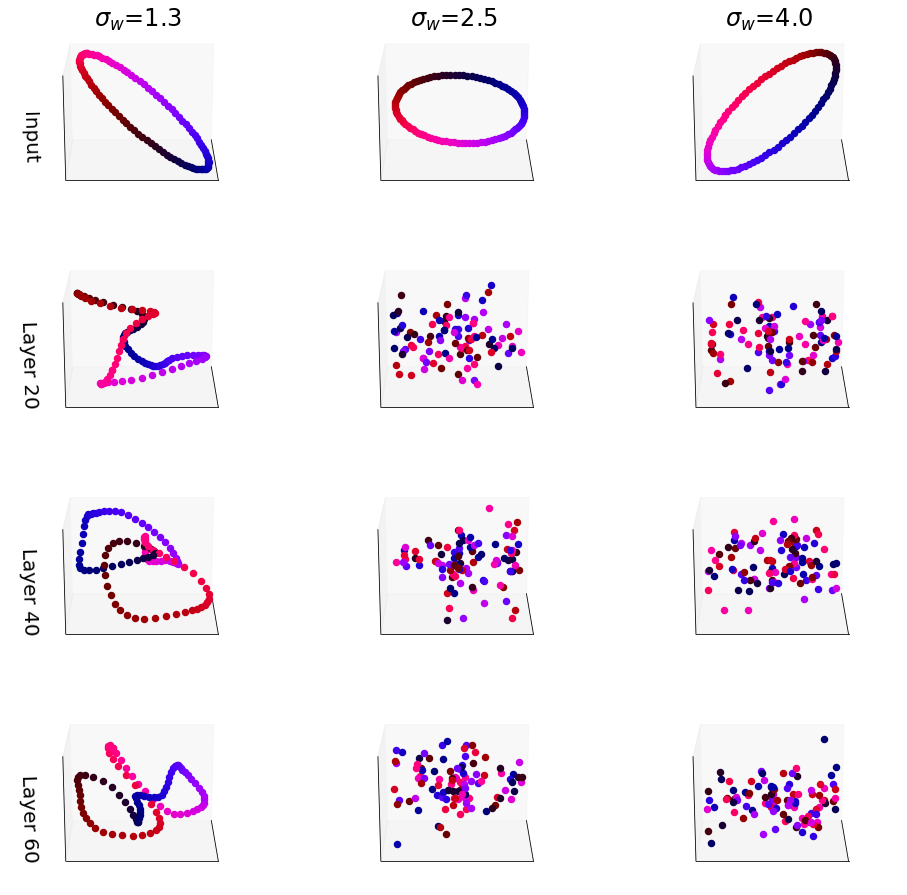

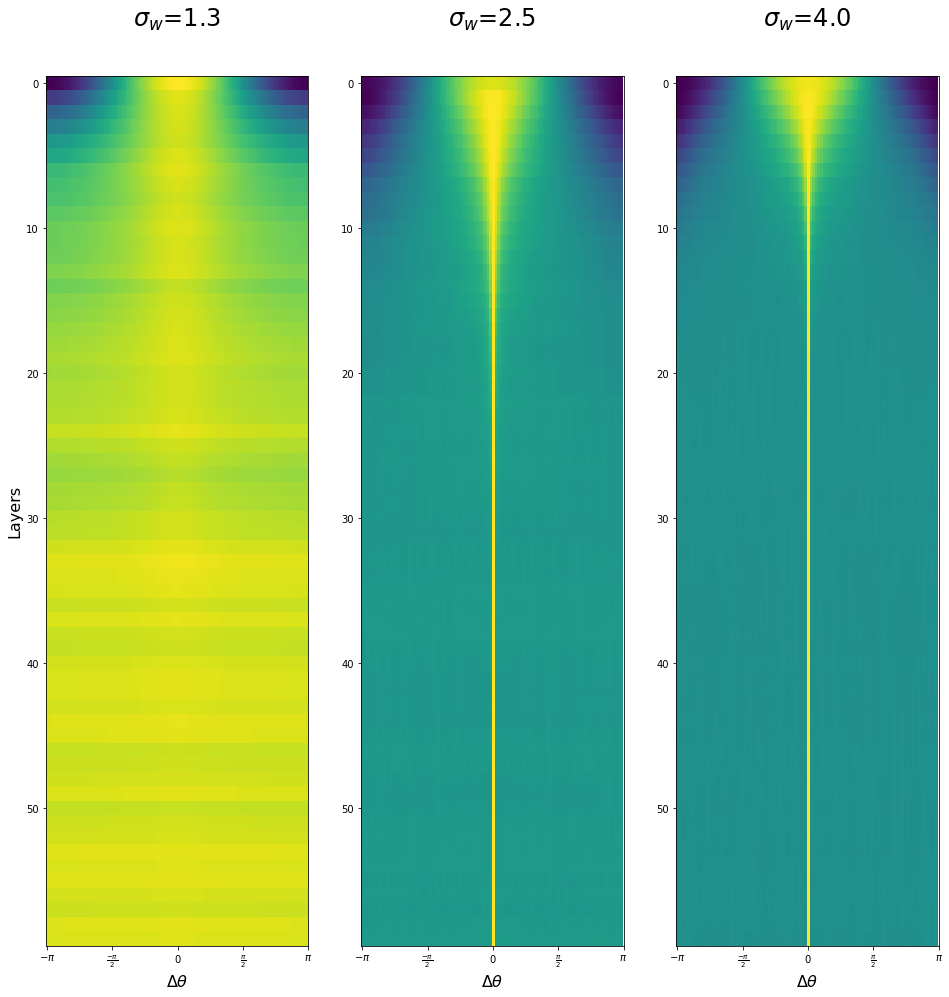

In [2]:


D = 60  ## 60 layers
N = 500 ## Input dimensions of 500
n = 100 ## numer of inputs



act1 = (lambda x: torch.tanh(x))
args1= dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = 1.3 ,SigmaB=0.3,activation=act1, desc = "$\sigma_w$=1.3")
act2 = (lambda x: torch.tanh(x))
args2= dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = 2.5 ,SigmaB=0.3,activation=act2, desc = "$\sigma_w$=2.5")
act3 = (lambda x: torch.tanh(x))
args3= dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = 4.0 ,SigmaB=0.3,activation=act3, desc = "$\sigma_w$=4.0")
src.visualization.compare([args1,args2,args3],display_every=20)

Here, we demonstrate the effect of changing the activation functions. 
We use the same initialization parameter as the winning example from before, but use activations that qunatize all hidden layer

In [ ]:
D = 20  ## 60 layers
N = 500 ## Input dimensions of 500
n = 100 ## numer of inputs

act1 = (lambda x: torch.sign(x))
args1= dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = 1.3, SigmaU=0.0 ,SigmaB=0.3,activation=act1, desc = "Sign")
act6 = (lambda x: src.activations.cast_intn(x,4))
args6= dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = 1.3, SigmaU=0.0 ,SigmaB=0.3,activation=act6, desc = "4bits")
act8 = (lambda x: src.activations.cast_intn(x,16))
args8= dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = 1.3, SigmaU=0.0 ,SigmaB=0.3,activation=act8, desc = "16bits")
act = (lambda x: torch.tanh(x))
args= dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = 1.3, SigmaU=0.0 ,SigmaB=0.3,activation=act, desc = "Tanh")
src.visualization.compare([args1,args6,args8,args],display_every=5)

This code generates a lightweight version of the results of figure #1 in the paper:

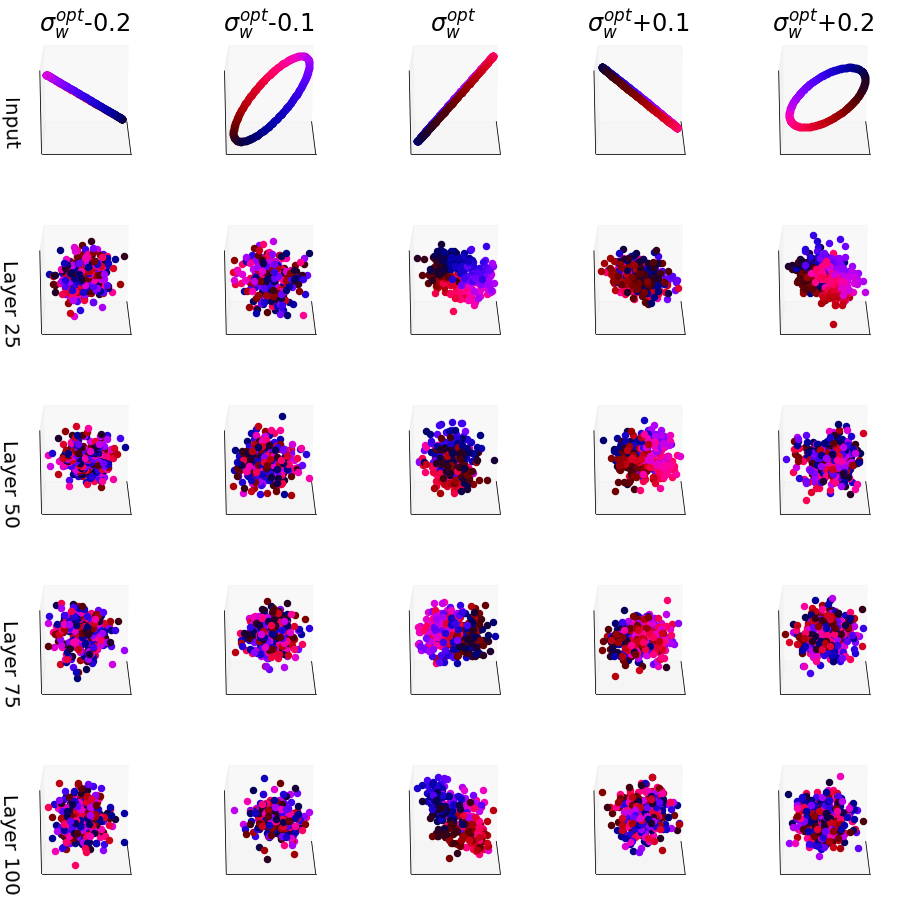

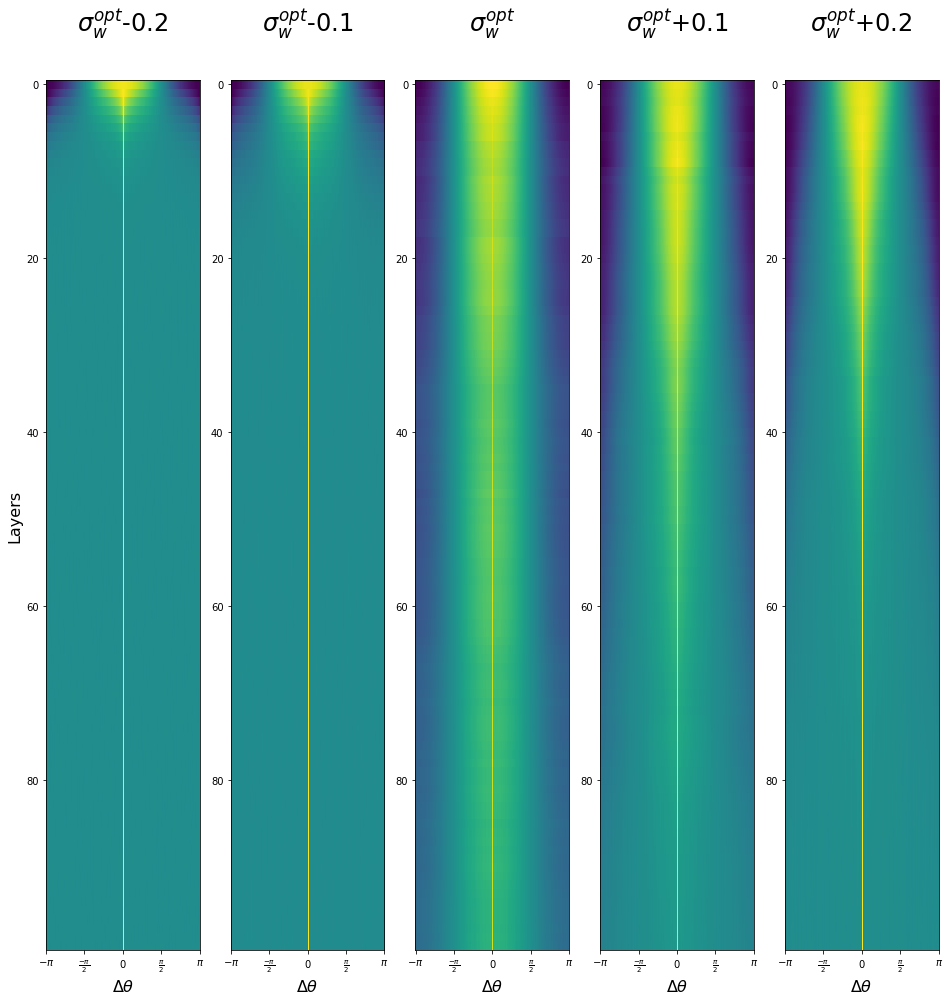

In [3]:
def gen_cast(x,offsets,const):
  N=offsets.numel()
  if x.is_cuda:
    res = torch.zeros(x.size()).cuda()
    factor=torch.Tensor([2*const/N]).cuda()
  else:
    res = torch.zeros(x.size())
    factor=torch.Tensor([2*const/N])
  if res.is_cuda and const.is_cuda:
    res=res-const
  elif not res.is_cuda or const.is_cuda:
    res=res-const.cpu()
  elif res.is_cuda or not const.is_cuda:
    res=res-const.cuda()
  for g in offsets:
    res+= factor*src.generalQ.heaviside(x - g)
  return res

N = 1000 ## Input dimensions of 500
n = 300 ## numer of inputs
D=100
args=[]
states = 16
offsets, scale , W, Qu = src.generalQ.optimal_spacing(states)
scale = torch.Tensor([scale]).cuda()
offsets = offsets.cuda()
act16 = (lambda x: gen_cast(x,offsets,scale))

arg = dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = W-0.2, SigmaU=0.0 ,SigmaB=0.001,activation=act16, desc = "$\sigma_{w}^{opt}$-0.2")
args.append(arg)
arg = dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = W-0.1, SigmaU=0.0 ,SigmaB=0.001,activation=act16, desc = "$\sigma_{w}^{opt}$-0.1")
args.append(arg)
arg = dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = W, SigmaU=0.0 ,SigmaB=0.001,activation=act16, desc = "$\sigma_{w}^{opt}$")
args.append(arg)
arg = dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = W+0.1, SigmaU=0.0 ,SigmaB=0.001,activation=act16, desc = "$\sigma_{w}^{opt}$+0.1")
args.append(arg)
arg = dargs(input_size= N,sim_time=D ,num_samples=n, mu=0.0, SigmaW = W+0.2, SigmaU=0.0 ,SigmaB=0.001,activation=act16, desc = "$\sigma_{w}^{opt}$+0.2")
args.append(arg)

##plt.subplots_adjust(wspace=10.0)
src.visualization.compare(args,display_every=25,autoCorrelations=True)